In [17]:
%matplotlib widget
import os
os.environ["GDAL_DATA"] = "/home/parndt/anaconda3/envs/geo_py37/share/gdal"
os.environ["PROJ_LIB"] = "/home/parndt/anaconda3/envs/geo_py37/share/proj"
import h5py
import math
# import datetime
import zipfile
import traceback
import shapely
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image, display
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches
from sklearn.neighbors import KDTree
from scipy.stats import binned_statistic
from scipy.signal import find_peaks

from lakeanalysis.utils import dictobj, convert_time_to_string, read_melt_lake_h5

In [18]:
# out_path_csv = 'data/lakestats_methods_paper.csv'
# df = pd.read_csv(out_path_csv)

In [19]:
# df_lakes = df.copy()
# maxdepths = []
# for i in range(len(df_lakes)):
# # for i in range(100):
#     print('reading file %5i / %5i' % (i+1, len(df_lakes)), end='\r')
#     fn = df_lakes.iloc[i].file_name
#     lk = dictobj(read_melt_lake_h5(fn))
#     dfd = lk.depth_data.copy()
    
#     isdepth = dfd.depth>0
#     bed = dfd.h_fit_bed
#     bed[~isdepth] = np.nan
#     bed[(dfd.depth>2) & (dfd.conf < 0.3)] = np.nan
#     bed[dfd.depth<0.9] = np.nan
#     surf = np.ones_like(dfd.xatc) * lk.surface_elevation
#     surf[~isdepth] = np.nan
#     bed_only = bed[(~np.isnan(surf)) & (~np.isnan(bed))]

#     if len(bed_only) == 0:
#         maxdepths.append(np.nan)
#     else:
#         y_low = np.percentile(bed_only, 5)
#         y_up = lk.surface_elevation
#         ref_index = 1.33
#         max_depth = (y_up - y_low) / ref_index
#         maxdepths.append(max_depth)

# df_lakes['depth_95th_pctl'] = maxdepths
# df_lakes.to_csv('data/lakestats_methods_paper_depth_update.csv', index=False)
# df_lakes

In [93]:
df_lakes = pd.read_csv('data/lakestats_methods_paper_depth_update.csv')
# df_lakes = df_lakes[df_lakes.quality_summary > 0]

In [60]:
np.percentile(dfg.surface_elevation, np.arange(0,101,10))

array([ 102.27614667,  796.66475397,  922.95631831, 1048.40288115,
       1168.36411602, 1216.62301562, 1277.47387769, 1318.79298369,
       1388.99875176, 1513.51953379, 1733.9174082 ])

In [114]:
from matplotlib.patches import Patch
def style_legend_titles_by_removing_handles(leg: matplotlib.legend.Legend) -> None:
    for col in leg._legend_handle_box.get_children():
        row = col.get_children()
        new_children: list[plt.Artist] = []
        for hpacker in row:
            if not isinstance(hpacker, matplotlib.offsetbox.HPacker):
                new_children.append(hpacker)
                continue
            drawing_area, text_area = hpacker.get_children()
            handle_artists = drawing_area.get_children()
            if not all(a.get_visible() for a in handle_artists):
                new_children.append(text_area)
            else:
                new_children.append(hpacker)
        col._children = new_children

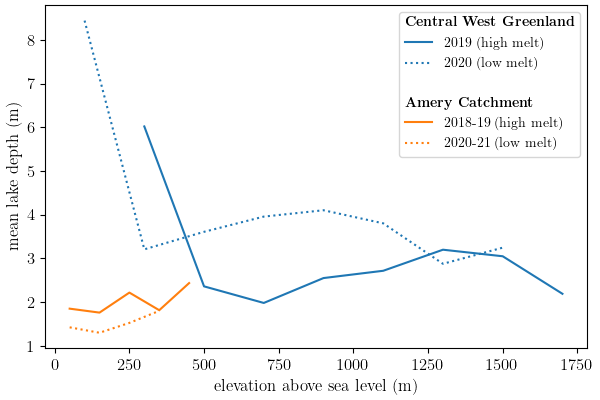

In [118]:
df_lakes=df_lakes[~np.isnan(df_lakes.depth_95th_pctl)]
dfg = df_lakes[df_lakes.ice_sheet == 'GrIS']
dfg19 = df_lakes[(df_lakes.ice_sheet == 'GrIS') & (df_lakes.melt_season=='2019')]
dfg20 = df_lakes[(df_lakes.ice_sheet == 'GrIS') & (df_lakes.melt_season=='2020')]
dfa = df_lakes[df_lakes.ice_sheet == 'AIS']
dfa18 = df_lakes[(df_lakes.ice_sheet == 'AIS') & (df_lakes.melt_season=='2018-19')]
dfa20 = df_lakes[(df_lakes.ice_sheet == 'AIS') & (df_lakes.melt_season=='2020-21')]
# stat='mean'
stat='median'
step = 200
maxelev = 2000
bins = np.arange(0, maxelev+step/2, step)
# bins = np.percentile(dfg.surface_elevation, np.arange(0,101,5))
mids_gre = bins[:-1] + np.diff(bins)/2
depthelev_gre = binned_statistic(dfg.surface_elevation, dfg.depth_95th_pctl, statistic=stat, bins=bins)
depthelev_gre19 = binned_statistic(dfg19.surface_elevation, dfg19.depth_95th_pctl, statistic=stat, bins=bins)
depthelev_gre20 = binned_statistic(dfg20.surface_elevation, dfg20.depth_95th_pctl, statistic=stat, bins=bins)
step = 100
maxelev = 500
bins = np.arange(0, maxelev+step/2, step)
mids_ant = bins[:-1] + np.diff(bins)/2
depthelev_ant = binned_statistic(dfa.surface_elevation, dfa.depth_95th_pctl, statistic=stat, bins=bins)
depthelev_ant18 = binned_statistic(dfa18.surface_elevation, dfa18.depth_95th_pctl, statistic=stat, bins=bins)
depthelev_ant20 = binned_statistic(dfa20.surface_elevation, dfa20.depth_95th_pctl, statistic=stat, bins=bins)

fig,ax = plt.subplots(figsize=[6,4])
g19, = ax.plot(mids_gre, depthelev_gre19.statistic, ls='-', c='C0', label='2019 (high melt)')
g20, = ax.plot(mids_gre, depthelev_gre20.statistic, ls=':', c='C0', label='2020 (low melt)')
a18, = ax.plot(mids_ant, depthelev_ant18.statistic, ls='-', c='C1', label='2018-19 (high melt)')
a20, = ax.plot(mids_ant, depthelev_ant20.statistic, ls=':', c='C1', label='2020-21 (low melt)')
empty_hdl = Patch(visible=False, label='')
cwhdl = Patch(visible=False, label=r'\textbf{Central West Greenland}')
bchdl = Patch(visible=False, label=r'\textbf{Amery Catchment}')
ax.set_xlabel('elevation above sea level (m)')
ax.set_ylabel('mean lake depth (m)')
hdls = [cwhdl, g19, g20, empty_hdl, bchdl, a18, a20]
leg = ax.legend(handles=hdls, loc='upper right', fontsize=10)
style_legend_titles_by_removing_handles(leg)
fig.tight_layout(pad=0.3)

In [110]:
a20

In [112]:
empty_handle = Patch(visible=False, label='')
empty_handle

 AIS 2018-19:  704  2.18  1.85 21.37
 AIS 2020-21:   26  2.23  1.48 14.23
GrIS    2019:  316  4.49  2.78 23.40
GrIS    2020:  173  4.49  3.44 17.30


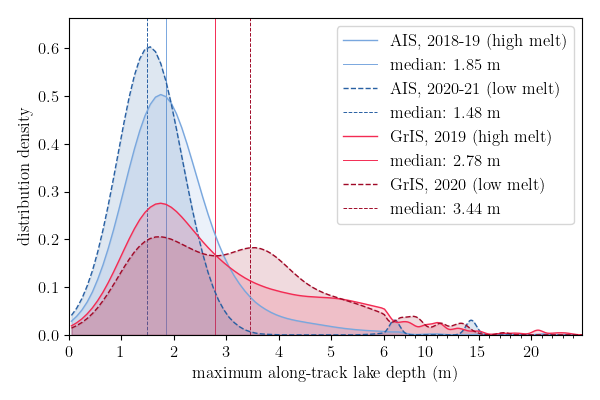

In [84]:
plt.rcParams.update({
    'font.size': 12,
    'text.usetex': True,
    'font.family': 'Optima'
})
colors = {
    'GrIS': '#D00C33', # Greenland flag
    'AIS': '#3A7DCE' # Antarctica, Graham Bartram Design
}
line_sty = {
    'low_melt': '--',
    'high_melt': '-'
}

season_type = {
    '2018-19': 'high_melt',
    '2020-21': 'low_melt',
    '2019': 'high_melt',
    '2020': 'low_melt'
}

melt_seasons = [
    '2018-19',
    '2020-21',
    '2019', 
    '2020',
]

density = True
collapse = True
collapse_start = 6
collapse_factor = 5

def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

fig, ax = plt.subplots(figsize=[6,4], dpi=100)
step = 0.25
step_s = 0.1
smooth = 1
uplim = 25
bins = np.arange(0,uplim+step/2,step)
mids = bins[:-1] + np.diff(bins)/2
bins_s = np.arange(0,uplim+step_s-0.1,step_s)
mids_s = bins_s[:-1] + np.diff(bins_s)/2
wdw = int(np.ceil(smooth/step_s))

if collapse: 
    mids_s[mids_s > collapse_start] = collapse_start + (mids_s[mids_s > collapse_start]-collapse_start) / collapse_factor
    coll_labs = np.array([5,10,15,20,25])
    coll_labs = coll_labs[coll_labs > collapse_start]
    coll_ticks = np.arange(0,collapse_start+1)
    coll_ticklabels = np.hstack((coll_ticks, coll_labs))
    coll_ticks = np.hstack((coll_ticks, collapse_start+((coll_labs-collapse_start)/collapse_factor)))
    minor_ticks = np.arange(0, uplim+1).astype(np.float64)
    minor_ticks[minor_ticks > collapse_start] = collapse_start + (minor_ticks[minor_ticks > collapse_start]-collapse_start) / collapse_factor

hdls = []
maxval = 0
medians = []
for melt_season in melt_seasons:
    sheet = 'AIS' if len(melt_season)>4 else 'GrIS'
    dfi = df_lakes[(df_lakes.melt_season == melt_season) & (~np.isnan(df_lakes.depth_95th_pctl))]
    sheet_name = 'Antarctic Ice Sheet' if sheet=='AIS' else 'Greenland Ice Sheet'
    print('%4s %7s: %4i %5.2f %5.2f %5.2f' % (
        sheet, 
        melt_season, 
        len(dfi), 
        dfi.depth_95th_pctl.mean(), 
        dfi.depth_95th_pctl.median(), 
        dfi.depth_95th_pctl.max()))
    medians.append(dfi.depth_95th_pctl.median())
    depths = np.clip(dfi.depth_95th_pctl, 0, uplim-step/2)
    
    hist = np.histogram(depths, bins=bins, density=density)[0]
    hist_s = np.histogram(depths, bins=bins_s, density=density)[0]
    
    hist_smooth = pd.Series(hist_s).rolling(window=wdw*3, center=True, min_periods=1, win_type='gaussian').mean(std=wdw/2)
    # hdl = ax.bar(mids, hist, np.diff(bins)[0], color=colors[sheet], alpha=0.3, label=sheet_name)
    # hdls.append(hdl)

    coladj = 1.3
    amt = coladj if season_type[melt_season] == 'high_melt' else 1/coladj
    thiscol = adjust_lightness(colors[sheet], amount=amt)
    hdl, = ax.plot(mids_s, hist_smooth, color=thiscol, lw=1.0, alpha=1.0,
                   label='%s, %s (%s)'%(sheet,melt_season,season_type[melt_season].replace('_', ' ')), 
                   ls=line_sty[season_type[melt_season]])
    ax.fill_between(mids_s, hist_smooth, color=thiscol, alpha=0.15)
    hdls.append(hdl)
    median = dfi.depth_95th_pctl.median()
    hdl, = ax.plot([median]*2, [0,100], lw=0.7, color=thiscol, 
                   label = 'median: %.2f m' % median,
                   ls=line_sty[season_type[melt_season]], zorder=-100)
    hdls.append(hdl)
    maxval = np.max((maxval, np.max(hist_smooth)))

if collapse:
    ax.set_xticks(coll_ticks)
    ax.set_xticklabels(coll_ticklabels)
    ax.set_xticks(minor_ticks, minor=True)

if density:
    ax.set_ylabel('distribution density')
else:
    ax.set_ylabel('number of lakes per %g m depth bin')
    
ax.set_xlabel('maximum along-track lake depth (m)')
ax.set_xlim((0,np.max(mids_s)))
ax.set_ylim((-0.001, 1.1*maxval))
ax.tick_params(axis='both')

ax.legend(handles=hdls)
fig.tight_layout()

if density:
    fn_plot_out = 'plots/depth_distributions_density.jpg'
else:
    fn_plot_out = 'plots/depth_distributions_counts.jpg'
if collapse:
    fn_plot_out = fn_plot_out.replace('.jpg', '_collapsed.jpg')
fig.savefig(fn_plot_out, dpi=600)

 AIS 2018-19:  704  2.18  1.85 21.37
 AIS 2020-21:   26  2.23  1.48 14.23
GrIS    2019:  316  4.49  2.78 23.40
GrIS    2020:  173  4.49  3.44 17.30


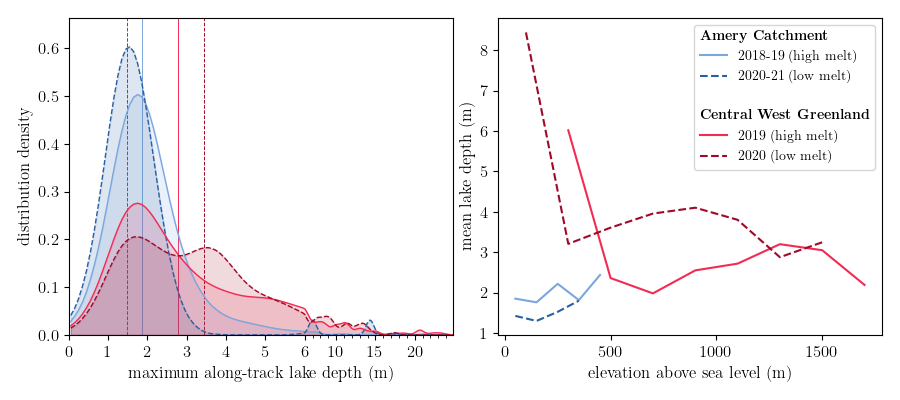

In [124]:
plt.rcParams.update({
    'font.size': 12,
    'text.usetex': True,
    'font.family': 'Optima'
})
colors = {
    'GrIS': '#D00C33', # Greenland flag
    'AIS': '#3A7DCE' # Antarctica, Graham Bartram Design
}
line_sty = {
    'low_melt': '--',
    'high_melt': '-'
}

season_type = {
    '2018-19': 'high_melt',
    '2020-21': 'low_melt',
    '2019': 'high_melt',
    '2020': 'low_melt'
}

melt_seasons = [
    '2018-19',
    '2020-21',
    '2019', 
    '2020',
]

density = True
collapse = True
collapse_start = 6
collapse_factor = 5

def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

fig = plt.figure(figsize=[9, 4], dpi=100)
gs = fig.add_gridspec(ncols=2, nrows=1)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax = ax1
step = 0.25
step_s = 0.1
smooth = 1
uplim = 25
bins = np.arange(0,uplim+step/2,step)
mids = bins[:-1] + np.diff(bins)/2
bins_s = np.arange(0,uplim+step_s-0.1,step_s)
mids_s = bins_s[:-1] + np.diff(bins_s)/2
wdw = int(np.ceil(smooth/step_s))

if collapse: 
    mids_s[mids_s > collapse_start] = collapse_start + (mids_s[mids_s > collapse_start]-collapse_start) / collapse_factor
    coll_labs = np.array([5,10,15,20,25])
    coll_labs = coll_labs[coll_labs > collapse_start]
    coll_ticks = np.arange(0,collapse_start+1)
    coll_ticklabels = np.hstack((coll_ticks, coll_labs))
    coll_ticks = np.hstack((coll_ticks, collapse_start+((coll_labs-collapse_start)/collapse_factor)))
    minor_ticks = np.arange(0, uplim+1).astype(np.float64)
    minor_ticks[minor_ticks > collapse_start] = collapse_start + (minor_ticks[minor_ticks > collapse_start]-collapse_start) / collapse_factor

hdls = []
maxval = 0
medians = []
for melt_season in melt_seasons:
    sheet = 'AIS' if len(melt_season)>4 else 'GrIS'
    dfi = df_lakes[(df_lakes.melt_season == melt_season) & (~np.isnan(df_lakes.depth_95th_pctl))]
    sheet_name = 'Antarctic Ice Sheet' if sheet=='AIS' else 'Greenland Ice Sheet'
    print('%4s %7s: %4i %5.2f %5.2f %5.2f' % (
        sheet, 
        melt_season, 
        len(dfi), 
        dfi.depth_95th_pctl.mean(), 
        dfi.depth_95th_pctl.median(), 
        dfi.depth_95th_pctl.max()))
    medians.append(dfi.depth_95th_pctl.median())
    depths = np.clip(dfi.depth_95th_pctl, 0, uplim-step/2)
    
    hist = np.histogram(depths, bins=bins, density=density)[0]
    hist_s = np.histogram(depths, bins=bins_s, density=density)[0]
    
    hist_smooth = pd.Series(hist_s).rolling(window=wdw*3, center=True, min_periods=1, win_type='gaussian').mean(std=wdw/2)
    # hdl = ax.bar(mids, hist, np.diff(bins)[0], color=colors[sheet], alpha=0.3, label=sheet_name)
    # hdls.append(hdl)

    coladj = 1.3
    amt = coladj if season_type[melt_season] == 'high_melt' else 1/coladj
    thiscol = adjust_lightness(colors[sheet], amount=amt)
    hdl, = ax.plot(mids_s, hist_smooth, color=thiscol, lw=1.0, alpha=1.0,
                   label='%s, %s (%s)'%(sheet,melt_season,season_type[melt_season].replace('_', ' ')), 
                   ls=line_sty[season_type[melt_season]])
    ax.fill_between(mids_s, hist_smooth, color=thiscol, alpha=0.15)
    hdls.append(hdl)
    median = dfi.depth_95th_pctl.median()
    hdl, = ax.plot([median]*2, [0,100], lw=0.7, color=thiscol, 
                   label = 'median: %.2f m' % median,
                   ls=line_sty[season_type[melt_season]], zorder=-100)
    hdls.append(hdl)
    maxval = np.max((maxval, np.max(hist_smooth)))

if collapse:
    ax.set_xticks(coll_ticks)
    ax.set_xticklabels(coll_ticklabels)
    ax.set_xticks(minor_ticks, minor=True)

if density:
    ax.set_ylabel('distribution density')
else:
    ax.set_ylabel('number of lakes per %g m depth bin')
    
ax.set_xlabel('maximum along-track lake depth (m)')
ax.set_xlim((0,np.max(mids_s)))
ax.set_ylim((-0.001, 1.1*maxval))
ax.tick_params(axis='both')

# ax.legend(handles=hdls, fontsize=10)

ax = ax2
df_lakes=df_lakes[~np.isnan(df_lakes.depth_95th_pctl)]
dfg = df_lakes[df_lakes.ice_sheet == 'GrIS']
dfg19 = df_lakes[(df_lakes.ice_sheet == 'GrIS') & (df_lakes.melt_season=='2019')]
dfg20 = df_lakes[(df_lakes.ice_sheet == 'GrIS') & (df_lakes.melt_season=='2020')]
dfa = df_lakes[df_lakes.ice_sheet == 'AIS']
dfa18 = df_lakes[(df_lakes.ice_sheet == 'AIS') & (df_lakes.melt_season=='2018-19')]
dfa20 = df_lakes[(df_lakes.ice_sheet == 'AIS') & (df_lakes.melt_season=='2020-21')]

stat='median'
step = 200
maxelev = 2000
bins = np.arange(0, maxelev+step/2, step)
mids_gre = bins[:-1] + np.diff(bins)/2
depthelev_gre = binned_statistic(dfg.surface_elevation, dfg.depth_95th_pctl, statistic=stat, bins=bins)
depthelev_gre19 = binned_statistic(dfg19.surface_elevation, dfg19.depth_95th_pctl, statistic=stat, bins=bins)
depthelev_gre20 = binned_statistic(dfg20.surface_elevation, dfg20.depth_95th_pctl, statistic=stat, bins=bins)
step = 100
maxelev = 500
bins = np.arange(0, maxelev+step/2, step)
mids_ant = bins[:-1] + np.diff(bins)/2
depthelev_ant = binned_statistic(dfa.surface_elevation, dfa.depth_95th_pctl, statistic=stat, bins=bins)
depthelev_ant18 = binned_statistic(dfa18.surface_elevation, dfa18.depth_95th_pctl, statistic=stat, bins=bins)
depthelev_ant20 = binned_statistic(dfa20.surface_elevation, dfa20.depth_95th_pctl, statistic=stat, bins=bins)

coladj = 1.3
amt = coladj if season_type[melt_season] == 'high_melt' else 1/coladj
thiscol = adjust_lightness(colors[sheet], amount=amt)
a18, = ax.plot(mids_ant, depthelev_ant18.statistic, ls='-', c=adjust_lightness(colors['AIS'],1.3), label='2018-19 (high melt)')
a20, = ax.plot(mids_ant, depthelev_ant20.statistic, ls='--', c=adjust_lightness(colors['AIS'],1/1.3), label='2020-21 (low melt)')
g19, = ax.plot(mids_gre, depthelev_gre19.statistic, ls='-', c=adjust_lightness(colors['GrIS'],1.3), label='2019 (high melt)')
g20, = ax.plot(mids_gre, depthelev_gre20.statistic, ls='--', c=adjust_lightness(colors['GrIS'],1/1.3), label='2020 (low melt)')
ax.set_xlabel('elevation above sea level (m)')
ax.set_ylabel('mean lake depth (m)')
empty_hdl = Patch(visible=False, label='')
cwhdl = Patch(visible=False, label=r'\textbf{Central West Greenland}')
bchdl = Patch(visible=False, label=r'\textbf{Amery Catchment}')
hdls = [bchdl, a18, a20, empty_hdl, cwhdl, g19, g20]
leg = ax.legend(handles=hdls, loc='upper right', fontsize=10)
style_legend_titles_by_removing_handles(leg)

fig.tight_layout(w_pad=0.3)

if density:
    fn_plot_out = 'plots/depth_distributions_density.jpg'
else:
    fn_plot_out = 'plots/depth_distributions_counts.jpg'
if collapse:
    fn_plot_out = fn_plot_out.replace('.jpg', '_collapsed.jpg')
fig.savefig(fn_plot_out, dpi=600)

 AIS 2018-19:  704  2.18  1.85 21.37
 AIS 2020-21:   26  2.23  1.48 14.23
GrIS    2019:  316  4.49  2.78 23.40
GrIS    2020:  173  4.49  3.44 17.30


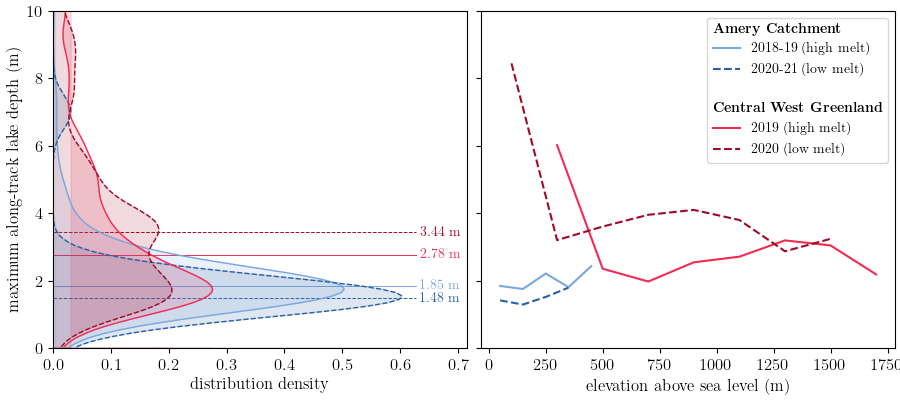

In [142]:
depthlims = [0,10]

plt.rcParams.update({
    'font.size': 12,
    'text.usetex': True,
    'font.family': 'Optima'
})
colors = {
    'GrIS': '#D00C33', # Greenland flag
    'AIS': '#3A7DCE' # Antarctica, Graham Bartram Design
}
line_sty = {
    'low_melt': '--',
    'high_melt': '-'
}

season_type = {
    '2018-19': 'high_melt',
    '2020-21': 'low_melt',
    '2019': 'high_melt',
    '2020': 'low_melt'
}

melt_seasons = [
    '2018-19',
    '2020-21',
    '2019', 
    '2020',
]

density = True
collapse = True

def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

fig = plt.figure(figsize=[9, 4], dpi=100)
gs = fig.add_gridspec(ncols=2, nrows=1)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)

ax = ax1
step = 0.25
step_s = 0.1
smooth = 1
uplim = 20
bins = np.arange(-1,uplim+step/2,step)
mids = bins[:-1] + np.diff(bins)/2
bins_s = np.arange(0,uplim+step_s-0.1,step_s)
mids_s = bins_s[:-1] + np.diff(bins_s)/2
wdw = int(np.ceil(smooth/step_s))

hdls = []
maxval = 0
medians = []
cols = []
lstys = []
for melt_season in melt_seasons:
    sheet = 'AIS' if len(melt_season)>4 else 'GrIS'
    dfi = df_lakes[(df_lakes.melt_season == melt_season) & (~np.isnan(df_lakes.depth_95th_pctl))]
    sheet_name = 'Antarctic Ice Sheet' if sheet=='AIS' else 'Greenland Ice Sheet'
    print('%4s %7s: %4i %5.2f %5.2f %5.2f' % (
        sheet, 
        melt_season, 
        len(dfi), 
        dfi.depth_95th_pctl.mean(), 
        dfi.depth_95th_pctl.median(), 
        dfi.depth_95th_pctl.max()))
    medians.append(dfi.depth_95th_pctl.median())
    depths = np.clip(dfi.depth_95th_pctl, 0, uplim-step/2)
    
    hist = np.histogram(depths, bins=bins, density=density)[0]
    hist_s = np.histogram(depths, bins=bins_s, density=density)[0]
    
    hist_smooth = pd.Series(hist_s).rolling(window=wdw*3, center=True, min_periods=1, win_type='gaussian').mean(std=wdw/2)

    coladj = 1.3
    amt = coladj if season_type[melt_season] == 'high_melt' else 1/coladj
    thiscol = adjust_lightness(colors[sheet], amount=amt)
    cols.append(thiscol)
    hdl, = ax.plot(hist_smooth, mids_s, color=thiscol, lw=1.0, alpha=1.0,
                   label='%s, %s (%s)'%(sheet,melt_season,season_type[melt_season].replace('_', ' ')), 
                   ls=line_sty[season_type[melt_season]])
    lstys.append(line_sty[season_type[melt_season]])
    ax.fill_between(hist_smooth,mids_s, 0, color=thiscol, alpha=0.15)
    hdls.append(hdl)
    # median = dfi.depth_95th_pctl.median()
    # medians.append(median)
    # hdl, = ax.plot([0,1],[median]*2, lw=0.7, color=thiscol, 
    #                label = 'median: %.2f m' % median,
    #                ls=line_sty[season_type[melt_season]], zorder=-100)
    # hdls.append(hdl)
    maxval = np.max((maxval, np.max(hist_smooth)))

if density:
    ax.set_xlabel('histogram density')
else:
    ax.set_xlabel('number of lakes per %g m depth bin')

xtent = np.array((0, 1.04*maxval))
for i, median in enumerate(medians): 
    ax.plot(xtent,[median]*2, lw=0.7, color=cols[i], 
                       label = 'median: %.2f m' % median,
                       ls=lstys[i], zorder=-100)
    ax.text(xtent[1]*1.01, median, '%.2f m' % median, ha='left', va='center', color=cols[i], fontsize=10)
    
ax.set_ylabel('maximum along-track lake depth (m)')
ax.set_xlim(xtent*1.14)
ax.set_ylim(depthlims)
ax.tick_params(axis='both')

ax = ax2
df_lakes=df_lakes[~np.isnan(df_lakes.depth_95th_pctl)]
dfg = df_lakes[df_lakes.ice_sheet == 'GrIS']
dfg19 = df_lakes[(df_lakes.ice_sheet == 'GrIS') & (df_lakes.melt_season=='2019')]
dfg20 = df_lakes[(df_lakes.ice_sheet == 'GrIS') & (df_lakes.melt_season=='2020')]
dfa = df_lakes[df_lakes.ice_sheet == 'AIS']
dfa18 = df_lakes[(df_lakes.ice_sheet == 'AIS') & (df_lakes.melt_season=='2018-19')]
dfa20 = df_lakes[(df_lakes.ice_sheet == 'AIS') & (df_lakes.melt_season=='2020-21')]

stat='median'
step = 200
maxelev = 2000
bins = np.arange(0, maxelev+step/2, step)
mids_gre = bins[:-1] + np.diff(bins)/2
depthelev_gre = binned_statistic(dfg.surface_elevation, dfg.depth_95th_pctl, statistic=stat, bins=bins)
depthelev_gre19 = binned_statistic(dfg19.surface_elevation, dfg19.depth_95th_pctl, statistic=stat, bins=bins)
depthelev_gre20 = binned_statistic(dfg20.surface_elevation, dfg20.depth_95th_pctl, statistic=stat, bins=bins)
step = 100
maxelev = 500
bins = np.arange(0, maxelev+step/2, step)
mids_ant = bins[:-1] + np.diff(bins)/2
depthelev_ant = binned_statistic(dfa.surface_elevation, dfa.depth_95th_pctl, statistic=stat, bins=bins)
depthelev_ant18 = binned_statistic(dfa18.surface_elevation, dfa18.depth_95th_pctl, statistic=stat, bins=bins)
depthelev_ant20 = binned_statistic(dfa20.surface_elevation, dfa20.depth_95th_pctl, statistic=stat, bins=bins)

coladj = 1.3
amt = coladj if season_type[melt_season] == 'high_melt' else 1/coladj
thiscol = adjust_lightness(colors[sheet], amount=amt)
a18, = ax.plot(mids_ant, depthelev_ant18.statistic, ls='-', c=adjust_lightness(colors['AIS'],1.3), label='2018-19 (high melt)')
a20, = ax.plot(mids_ant, depthelev_ant20.statistic, ls='--', c=adjust_lightness(colors['AIS'],1/1.3), label='2020-21 (low melt)')
g19, = ax.plot(mids_gre, depthelev_gre19.statistic, ls='-', c=adjust_lightness(colors['GrIS'],1.3), label='2019 (high melt)')
g20, = ax.plot(mids_gre, depthelev_gre20.statistic, ls='--', c=adjust_lightness(colors['GrIS'],1/1.3), label='2020 (low melt)')
ax.set_xlabel('elevation above sea level (m)')
# ax.set_ylabel('mean lake depth (m)')
empty_hdl = Patch(visible=False, label='')
cwhdl = Patch(visible=False, label=r'\textbf{Central West Greenland}')
bchdl = Patch(visible=False, label=r'\textbf{Amery Catchment}')
hdls = [bchdl, a18, a20, empty_hdl, cwhdl, g19, g20]
leg = ax.legend(handles=hdls, loc='upper right', fontsize=10)
style_legend_titles_by_removing_handles(leg)
plt.setp(ax.get_yticklabels(), visible=False)

fig.tight_layout(pad=0.3)

if density:
    fn_plot_out = 'plots/depth_distributions_density.jpg'
else:
    fn_plot_out = 'plots/depth_distributions_counts.jpg'
if collapse:
    fn_plot_out = fn_plot_out.replace('.jpg', '_collapsed.jpg')
fig.savefig(fn_plot_out, dpi=600)

In [129]:
medians

[1.8542219255400165,
 1.8542219255400165,
 1.4820176708039314,
 1.4820176708039314,
 2.7777271910754893,
 2.7777271910754893,
 3.441793806525099,
 3.441793806525099]

/Users/parndt/jupyterprojects/icelakes-methods/data/lakes/lake_09999643_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20181230073914_00280212_006_02_gt2r_0025.h5


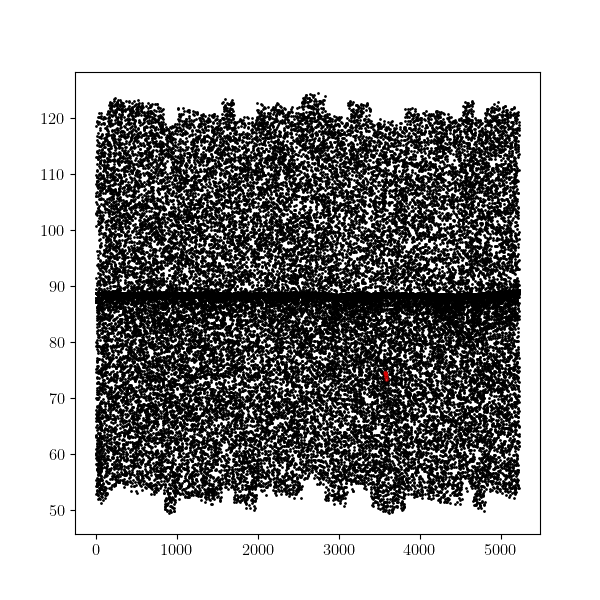

In [88]:
dfi = pd.read_csv('data/lakestats_methods_paper_depth_update.csv')
dfi = dfi.sort_values(by='depth_95th_pctl', ascending=False)
for i in [4]:
    fn = dfi.iloc[i].file_name
    print(fn)
    lk = dictobj(read_melt_lake_h5(fn))
    df = lk.photon_data
    dfd = lk.depth_data.copy()
    
    isdepth = dfd.depth>0
    bed = dfd.h_fit_bed
    bed[~isdepth] = np.nan
    bed[(dfd.depth>2) & (dfd.conf < 0.3)] = np.nan
    surf = np.ones_like(dfd.xatc) * lk.surface_elevation
    surf[~isdepth] = np.nan
    bed[np.isnan(surf)] = np.nan
    
    fig, ax = plt.subplots(figsize=[6,6], dpi=100)
    ax.scatter(df.xatc, df.h, s=1, c='k')
    # ax.plot(dfd.xatc, bed, 'r-')
    
    # ax.scatter(dfd.xatc, bed, s=5, c='r', alpha=dfd.conf)
    alph = np.array(dfd.conf)
    alph[alph<0.5] = 0.0
    ax.scatter(dfd.xatc, bed, s=5, color='r', alpha=alph)

In [75]:
dfi = pd.read_csv('data/lakestats_methods_paper_depth_update.csv')

,ice_sheet,melt_season,basin,quality_summary,max_depth,length_water_surfaces,surface_elevation,n_photons_where_water,lon,lat,...,beam_strength,beam_number,detection_quality,lake_quality,granule_id,lake_id,file_name,main_region,basin_name,depth_95th_pctl
345,AIS,2020-21,ANT_1000_East_B-C,0.013809,13.766468,2080.0,216.741479,34823,67.852018,-72.944620,...,strong,1,0.138080,0.000000,ATL03_20210204190842_06531012_006_01.h5,simplified_ANT_1000_East_B-C_ATL03_20210204190...,/Users/parndt/jupyterprojects/icelakes-methods...,AIS_East,B-C,14.233578
528,AIS,2020-21,ANT_1000_East_B-C,0.001298,6.295103,3243.0,216.763752,13900,67.850648,-72.947241,...,weak,2,0.012969,0.000000,ATL03_20210204190842_06531012_006_01.h5,simplified_ANT_1000_East_B-C_ATL03_20210204190...,/Users/parndt/jupyterprojects/icelakes-methods...,AIS_East,B-C,6.942317
588,AIS,2020-21,ANT_1000_East_B-C,0.000658,2.004537,609.0,65.943590,24090,71.059363,-71.743835,...,strong,5,0.006568,0.000000,ATL03_20210111071058_02791010_006_01.h5,simplified_ANT_1000_East_B-C_ATL03_20210111071...,/Users/parndt/jupyterprojects/icelakes-methods...,AIS_East,B-C,2.048037
385,AIS,2020-21,ANT_1000_East_B-C,0.007546,1.902528,150.0,551.603564,6101,68.084708,-73.348575,...,strong,3,0.075449,0.000000,ATL03_20210123064559_04621010_006_01.h5,simplified_ANT_1000_East_B-C_ATL03_20210123064...,/Users/parndt/jupyterprojects/icelakes-methods...,AIS_East,B-C,1.948311
561,AIS,2020-21,ANT_1000_East_B-C,0.000930,1.746448,760.0,52.872139,18187,71.082142,-71.682794,...,weak,6,0.009286,0.000000,ATL03_20210111071058_02791010_006_01.h5,simplified_ANT_1000_East_B-C_ATL03_20210111071...,/Users/parndt/jupyterprojects/icelakes-methods...,AIS_East,B-C,1.833536
409,AIS,2020-21,ANT_1000_East_B-C,0.005627,2.368535,306.0,219.531753,6624,69.551560,-72.440198,...,weak,4,0.056263,0.000000,ATL03_20201118095027_08430910_006_01.h5,simplified_ANT_1000_East_B-C_ATL03_20201118095...,/Users/parndt/jupyterprojects/icelakes-methods...,AIS_East,B-C,1.767585
1145,AIS,2020-21,ANT_1000_East_B-C,0.000003,1.689142,109.0,16.676807,1386,68.265221,-70.726061,...,strong,5,0.000019,0.000000,ATL03_20210127192522_05311012_006_01.h5,simplified_ANT_1000_East_B-C_ATL03_20210127192...,/Users/parndt/jupyterprojects/icelakes-methods...,AIS_East,B-C,1.703229
458,AIS,2020-21,ANT_1000_East_B-C,0.002667,1.366911,368.0,205.675372,6599,67.444895,-73.079346,...,strong,1,0.026660,0.000000,ATL03_20210106203237_02111012_006_01.h5,simplified_ANT_1000_East_B-C_ATL03_20210106203...,/Users/parndt/jupyterprojects/icelakes-methods...,AIS_East,B-C,1.434333
252,AIS,2020-21,ANT_1000_East_B-C,0.079082,1.320874,490.0,396.359133,19576,67.763784,-73.265334,...,strong,5,0.059233,1.234881,ATL03_20201225080953_00201010_006_01.h5,simplified_ANT_1000_East_B-C_ATL03_20201225080...,/Users/parndt/jupyterprojects/icelakes-methods...,AIS_East,B-C,1.346338
1151,AIS,2020-21,ANT_1000_East_B-C,0.000002,0.814727,502.0,162.659281,10553,66.583981,-73.006386,...,strong,1,0.000000,0.134618,ATL03_20210313172806_12171012_006_01.h5,simplified_ANT_1000_East_B-C_ATL03_20210313172...,/Users/parndt/jupyterprojects/icelakes-methods...,AIS_East,B-C,1.297275


GrIS 2019 3.960970309406941 21.02599953605911
GrIS 2020 4.0471053002594495 14.419924402023527
AIS 2018-19 1.881731376884545 21.03139352480226
AIS 2020-21 1.7773064754252743 12.381517670235567


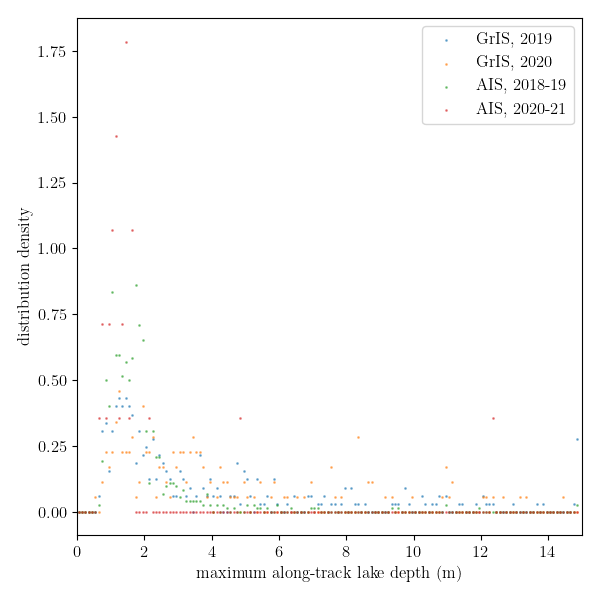

In [25]:
plt.rcParams.update({
    'font.size': 12,
    'text.usetex': True,
    'font.family': 'Optima'
})
colors = {
    'GrIS': '#D00C33', # Greenland flag
    'AIS': '#3A7DCE' # Antarctica, Graham Bartram Design
}
line_sty = {
    'low_melt': '--',
    'high_melt': '-'
}

season_type = {
    '2018-19': 'high_melt',
    '2020-21': 'low_melt',
    '2019': 'high_melt',
    '2020': 'low_melt'
}

fig, ax = plt.subplots(figsize=[6,6], dpi=100)
step = 0.25
step_s = 0.1
smooth = 2
uplim = 15
bins = np.arange(0,uplim+step/2,step)
mids = bins[:-1] + np.diff(bins)/2
bins_s = np.arange(0,uplim+step_s-0.1,step_s)
mids_s = bins_s[:-1] + np.diff(bins_s)/2
wdw = int(np.ceil(smooth/step_s))

hdls = []

for i, melt_season in enumerate(['2019', '2020', '2018-19', '2020-21']):
    sheet = 'AIS' if len(melt_season)>4 else 'GrIS'
    dfi = df_lakes[df_lakes.melt_season == melt_season]
    sheet_name = 'Antarctic Ice Sheet' if sheet=='AIS' else 'Greenland Ice Sheet'
    print(sheet, melt_season, dfi.depth_90th_pctl.mean(), dfi.depth_90th_pctl.max())
    depths = np.clip(dfi.depth_90th_pctl, 0, uplim-step/2)
    hist = np.histogram(depths, bins=bins, density=True)[0]
    hist_s = np.histogram(depths, bins=bins_s, density=True)[0]
    hist_smooth = pd.Series(hist_s).rolling(window=wdw, center=True, min_periods=1).mean()
    # hdl = ax.bar(mids, hist, np.diff(bins)[0], color=colors[sheet], alpha=0.3, label=sheet_name)
    # hdls.append(hdl)
    hdl = ax.scatter(mids_s, hist_s, s=1, c='C%i' % i, alpha=0.5, label='%s, %s' % (sheet, melt_season))
    # hdl, = ax.plot(mids_s, hist_smooth, color=colors[sheet], label=sheet_name, ls=line_sty[season_type[melt_season]])
    hdls.append(hdl)
    ax.set_ylabel('distribution density')
    ax.set_xlabel('maximum along-track lake depth (m)')
    ax.set_xlim((0,uplim))
    ax.tick_params(axis='both')

ax.legend(handles=hdls)
fig.tight_layout()

# fig.savefig('plots/depth_distributions.jpg', dpi=600)

In [2]:
out_path_csv = 'data/lakestats_methods_paper.csv'
df = pd.read_csv(out_path_csv)

fn_basin = 'basins/shapefiles/Basins_Antarctica_v02.shp'
fn_shelf = 'basins/shapefiles/IceShelf_Antarctica_v02.shp'
fn_coast = 'basins/shapefiles/Coastline_Antarctica_v02.shp'
fn_ground = 'basins/shapefiles/GroundingLine_Antarctica_v02.shp'
fn_merged =  'basins/shapefiles/ANT_basins_merged.shp'
fn_thresh = 'basins/shapefiles/ANT_basins_thresh1000.shp'

ant_gdf_basin = gpd.read_file(fn_basin)
ant_gdf_shelf = gpd.read_file(fn_shelf)
ant_gdf_coast = gpd.read_file(fn_coast)
ant_gdf_ground = gpd.read_file(fn_ground)
ant_gdf_merged = gpd.read_file(fn_merged)
ant_gdf_thresh = gpd.read_file(fn_thresh)

fn_basin = 'basins/shapefiles/Greenland_Basins_PS_v1.4.2.shp'
fn_merged = 'basins/shapefiles/GRE_basins_merged.shp'
fn_thresh = 'basins/shapefiles/GRE_basins_thresh2000.shp'
gre_gdf_basin = gpd.read_file(fn_basin)
gre_gdf_basin['geometry'] = gre_gdf_basin.geometry.buffer(1)
gre_gdf_merged = gpd.read_file(fn_merged)
gre_gdf_thresh = gpd.read_file(fn_thresh)

gre_bound = gre_gdf_basin.dissolve().boundary
ant_bound = ant_gdf_basin.dissolve().boundary

In [18]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Optima"
})

min_area = 0.01
melt_color = '#0692cf'

def plot_region(region, meltseasons):
    if region == 'B-C':
        base_crs = 'EPSG:3031'
        region_thresh = ant_gdf_thresh[ant_gdf_thresh.Subregions == region]
        bound = ant_bound
        amery = ant_gdf_shelf[ant_gdf_shelf.NAME == 'Amery']
        fig, axs = plt.subplots(figsize=[6,6], nrows=2, ncols=1)
        leg_loc = 'upper left'
    if region == 'CW':
        base_crs = 'EPSG:3413'
        region_thresh = gre_gdf_thresh[gre_gdf_thresh.SUBREGION1 == region]
        bound = gre_bound
        fig, axs = plt.subplots(figsize=[6,6], nrows=1, ncols=2)
        leg_loc = 'upper right'

    
    dfl = df[df.basin_name == region]
    axs = axs.flatten()
    for i, meltseason in enumerate(meltseasons):
        dfs = dfl[dfl.melt_season == meltseason]
        gdfs = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.lon, dfs.lat), crs="EPSG:4326").to_crs(region_thresh.crs)
        gdfs['x'] = gdfs.apply(lambda x: x.geometry.x, axis=1)
        gdfs['y'] = gdfs.apply(lambda x: x.geometry.y, axis=1)
        
        ax = axs[i]
        region_thresh.plot(color='gray', ax=ax, lw=0, alpha=0.3, zorder=-200)
        xl = ax.get_xlim()
        yl = ax.get_ylim()
        bound.plot(color='k', ax=ax, lw=0.5, zorder=-100)
        if region == 'B-C':
            amery.plot(color='blue', alpha=0.05, ax=ax, lw=0)
            amery.exterior.plot(color='blue', ax=ax, lw=0.2)
            ant_gdf_shelf.boundary.plot(color='gray', ax=ax, lw=0.2, zorder=-100)
            
        scattlabel = r'ICESat-2 lakes: $%i$ total' % len(dfs)
        if region == 'CW':
            scattlabel = scattlabel.replace(':', ':\n')
        scatt = ax.scatter(gdfs.x, gdfs.y, s=2, c='r', alpha=1, zorder=100, label=scattlabel)

        ext = gpd.read_file('region_shapefiles/extents/%s_extent_%s.geojson' % (region,meltseason.replace('-', '_')))\
        .explode(index_parts=False).to_crs(base_crs)
        patch_areas = ext.geometry.area / 1e6
        ext = ext[patch_areas > min_area].simplify(60)
        total_area = np.sum(patch_areas[patch_areas > min_area])
        ext_plot = ext.buffer(200).simplify(100).plot(ax=ax, color=melt_color)    
        
        ax.set_xlim(xl)
        ax.set_ylim(yl)
        ax.axis('off')
        ax.set_title('%s' % meltseason, fontsize=14)

        patchlabel = r'Landsat melt extent: $%.1f$ km$^2$' % total_area
        if region == 'CW':
            patchlabel = patchlabel.replace(':', ':\n').replace('Landsat ', 'Landsat\n')
        melt_patch = mpatches.Patch(color=melt_color, label=patchlabel)
        ax.legend(handles=[scatt,melt_patch], loc=leg_loc, fontsize=7)
    
    fig.tight_layout()
    fig.savefig('plots/methods_selection_%s.jpg' % region, dpi=600)

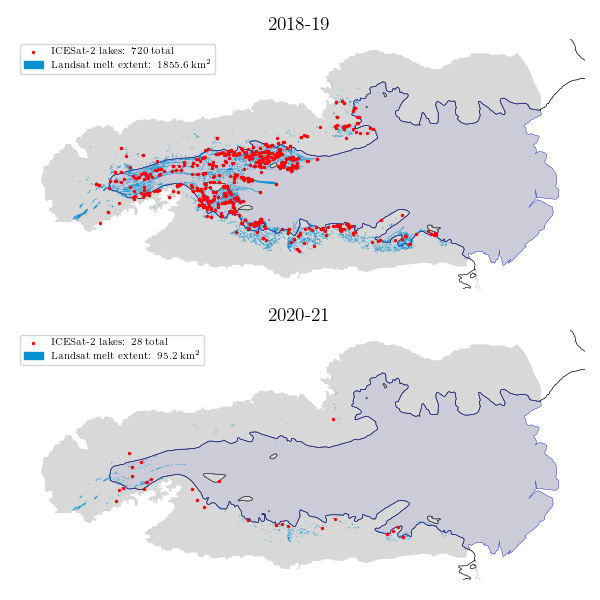

In [19]:
plot_region(region='B-C', meltseasons=['2018-19', '2020-21'])

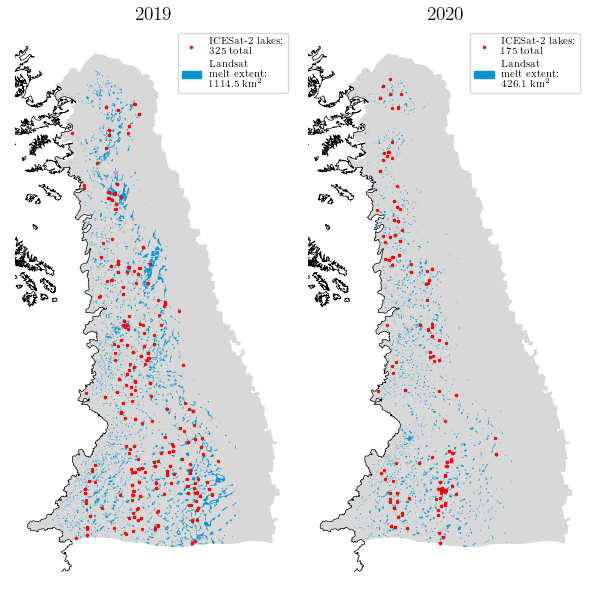

In [20]:
plot_region(region='CW', meltseasons=['2019', '2020'])

In [ ]:
min_area = 0.05
ext = gpd.read_file('region_shapefiles/extents/B-C_extent_2018_19.geojson')\
    .explode(index_parts=False).to_crs('EPSG:3031')
patch_areas = ext.geometry.area / 1e6
ext = ext[patch_areas > min_area].simplify(60)

In [ ]:
df_bc = df[df.basin_name=='B-C']
df_bc.fn_only.iloc[0]

In [ ]:
! ls data/lakes/*_AIS_2018-19_simplified_ANT_1000_East_B-C_* | wc -l
! ls data/lakes/*_AIS_2020-21_simplified_ANT_1000_East_B-C_* | wc -l

In [ ]:
# ! cp ../IceLakesRun2/detection_out_data/*_AIS_2018-19_simplified_ANT_1000_East_B-C_* ../IceLakesRun2/methods_data
# ! cp ../IceLakesRun2/detection_out_data/*_AIS_2020-21_simplified_ANT_1000_East_B-C_* ../IceLakesRun2/methods_data

In [ ]:
df_bc = df[df.basin_name=='CW']
df_bc.fn_only.iloc[0]

In [ ]:
! ls data/lakes/*_GrIS_2019_simplified_GRE_2000_CW_* | wc -l
! ls data/lakes/*_GrIS_2020_simplified_GRE_2000_CW_* | wc -l

In [ ]:
# ! cp ../IceLakesRun2/detection_out_data/*_GrIS_2019_simplified_GRE_2000_CW_* ../IceLakesRun2/methods_data
# ! cp ../IceLakesRun2/detection_out_data/*_GrIS_2020_simplified_GRE_2000_CW_* ../IceLakesRun2/methods_data

In [ ]:
r'Landsat melt extent: $%.1f$ km$^2$' % total_area

In [ ]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Optima"
})

min_area = 0.01
melt_color = '#0692cf'

def plot_region(region, melt_seasons):
    if region == 'B-C':
        base_crs = 'EPSG:3031'
        region_thresh = ant_gdf_thresh[ant_gdf_thresh.Subregions == region]
        bound = ant_bound
        amery = ant_gdf_shelf[ant_gdf_shelf.NAME == 'Amery']
        fig, axs = plt.subplots(figsize=[6,6], nrows=2, ncols=1)
    if region == 'CW':
        base_crs = 'EPSG:3413'
        region_thresh = gre_gdf_thresh[gre_gdf_thresh.SUBREGION1 == region]
        bound = gre_bound
        fig, axs = plt.subplots(figsize=[6,6], nrows=1, ncols=2)

    
    dfl = df[df.basin_name == region]
    axs = axs.flatten()
    for i, meltseason in enumerate(meltseasons):
        dfs = dfl[dfl.melt_season == meltseason]
        print(meltseason, len(dfs))
        gdfs = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.lon, dfs.lat), crs="EPSG:4326").to_crs(region_thresh.crs)
        gdfs['x'] = gdfs.apply(lambda x: x.geometry.x, axis=1)
        gdfs['y'] = gdfs.apply(lambda x: x.geometry.y, axis=1)
        
        ax = axs[i]
        region_thresh.plot(color='gray', ax=ax, lw=0, alpha=0.3, zorder=-200)
        xl = ax.get_xlim()
        yl = ax.get_ylim()
        bound.plot(color='k', ax=ax, lw=0.5, zorder=-100)
        if region == 'B-C':
            amery.plot(color='blue', alpha=0.05, ax=ax, lw=0)
            amery.exterior.plot(color='blue', ax=ax, lw=0.2)
            ant_gdf_shelf.boundary.plot(color='gray', ax=ax, lw=0.2, zorder=-100)
    
        scatt = ax.scatter(gdfs.x, gdfs.y, s=2, c='r', alpha=1, zorder=100, 
                           label=r'ICESat-2 lakes: $%i$ total' % len(dfs))

        ext = gpd.read_file('region_shapefiles/extents/%s_extent_%s.geojson' % (region,meltseason.replace('-', '_')))\
        .explode(index_parts=False).to_crs(base_crs)
        patch_areas = ext.geometry.area / 1e6
        ext = ext[patch_areas > min_area].simplify(60)
        total_area = np.sum(patch_areas[patch_areas > min_area])
        ext_plot = ext.buffer(200).simplify(100).plot(ax=ax, color=melt_color)    
        
        ax.set_xlim(xl)
        ax.set_ylim(yl)
        ax.axis('off')
        ax.set_title('%s' % meltseason)
    
        melt_patch = mpatches.Patch(color=melt_color, label=r'Landsat melt extent: $%.1f$ km$^2$' % total_area)
        ax.legend(handles=[scatt,melt_patch], loc='upper left', fontsize=8)
    
    fig.tight_layout()
    # fig.savefig('plots/methods_selection_%s.jpg' % region, dpi=600)

In [ ]:
region = 'B-C'
min_area = 0.01
base_crs = 'EPSG:3031'
meltseasons = ['2018-19', '2020-21']
melt_color = '#0692cf'

region_thresh = ant_gdf_thresh[ant_gdf_thresh.Subregions == region]
amery = ant_gdf_shelf[ant_gdf_shelf.NAME == 'Amery']
dfl = df[df.basin_name == region]

fig, axs = plt.subplots(figsize=[6,6], nrows=2, ncols=1)
axs = axs.flatten()

for i, meltseason in enumerate(meltseasons):
    dfs = dfl[dfl.melt_season == meltseason]
    print(meltseason, len(dfs))
    gdfs = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.lon, dfs.lat), crs="EPSG:4326").to_crs(region_thresh.crs)
    gdfs['x'] = gdfs.apply(lambda x: x.geometry.x, axis=1)
    gdfs['y'] = gdfs.apply(lambda x: x.geometry.y, axis=1)
    
    ax = axs[i]
    # region_thresh.exterior.plot(color='k', ax=ax, lw=1)
    region_thresh.plot(color='gray', ax=ax, lw=0, alpha=0.3, zorder=-200)
    xl = ax.get_xlim()
    yl = ax.get_ylim()
    amery.plot(color='blue', alpha=0.05, ax=ax, lw=0)
    amery.exterior.plot(color='blue', ax=ax, lw=0.2)
    ant_bound.plot(color='k', ax=ax, lw=0.5, zorder=-100)
    ant_gdf_shelf.boundary.plot(color='gray', ax=ax, lw=0.2, zorder=-100)

    scatt = ax.scatter(gdfs.x, gdfs.y, s=2, c='r', alpha=1, zorder=100, 
                       label=r'ICESat-2 lakes: $%i$ total' % len(dfs))

    ext = gpd.read_file('region_shapefiles/extents/%s_extent_%s.geojson' % (region,meltseason.replace('-', '_')))\
    .explode(index_parts=False).to_crs(base_crs)
    patch_areas = ext.geometry.area / 1e6
    ext = ext[patch_areas > min_area].simplify(60)
    total_area = np.sum(patch_areas[patch_areas > min_area])
    ext_plot = ext.buffer(200).simplify(100).plot(ax=ax, color=melt_color)    
    
    ax.set_xlim(xl)
    ax.set_ylim(yl)
    ax.axis('off')
    ax.set_title('%s' % meltseason)

    melt_patch = mpatches.Patch(color=melt_color, label=r'Landsat melt extent: $%.1f$ km$^2$' % total_area)
    ax.legend(handles=[scatt,melt_patch], loc='upper left', fontsize=8)

fig.tight_layout()
# fig.savefig('plots/methods_selection_%s.jpg' % region, dpi=600)

In [ ]:
region = 'B-C'
meltseasons = ['2018-19']
meltseasons = []
for y in np.arange(2018,2023):
    meltseasons.append(str(y) + '-' + str(y+1)[2:])

region_thresh = ant_gdf_thresh[ant_gdf_thresh.Subregions == region]
amery = ant_gdf_shelf[ant_gdf_shelf.NAME == 'Amery']
dfl = df[df.basin_name == region]

fig, axs = plt.subplots(figsize=[8,6], nrows=3, ncols=2)
axs = axs.flatten()
axs[5].axis('off')

for i, meltseason in enumerate(meltseasons):
    dfs = dfl[dfl.melt_season == meltseason]
    print(meltseason, len(dfs))
    gdfs = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.lon, dfs.lat), crs="EPSG:4326").to_crs(region_thresh.crs)
    gdfs['x'] = gdfs.apply(lambda x: x.geometry.x, axis=1)
    gdfs['y'] = gdfs.apply(lambda x: x.geometry.y, axis=1)
    
    ax = axs[i]
    # region_thresh.exterior.plot(color='k', ax=ax, lw=1)
    region_thresh.plot(color='gray', ax=ax, lw=0, alpha=0.3, zorder=-200)
    xl = ax.get_xlim()
    yl = ax.get_ylim()
    amery.plot(color='blue', alpha=0.05, ax=ax, lw=0)
    amery.exterior.plot(color='blue', ax=ax, lw=0.2)
    ant_bound.plot(color='k', ax=ax, lw=0.5, zorder=-100)
    ant_gdf_shelf.boundary.plot(color='gray', ax=ax, lw=0.2, zorder=-100)

    # ax.scatter(gdfs.x, gdfs.y, s=0.5, c='r', alpha=0.5, zorder=100)

    ext = gpd.read_file('region_shapefiles/extents/B-C_extent_%s.geojson' % meltseason.replace('-', '_'))\
    .explode(index_parts=False).to_crs('EPSG:3031')
    patch_areas = ext.geometry.area / 1e6
    ext = ext[patch_areas > min_area].simplify(60)
    total_area = np.sum(patch_areas[patch_areas > min_area])
    ext.buffer(100).simplify(100).plot(ax=ax, color='#0692cf')    
    
    ax.set_xlim(xl)
    ax.set_ylim(yl)
    ax.axis('off')
    ax.set_title('%s: %.1f km^2' % (meltseason, total_area))
    # ax.set_title('%s: %i lakes' % (meltseason, len(dfs)))
    ax.set_title('%s: %i lakes | %.1f km^2' % (meltseason,  len(dfs), total_area))

fig.tight_layout()
fig.savefig('plots/methods_selection_%s.jpg' % region, dpi=600)

In [ ]:
base_tiled = region_thresh.rename(columns={"Subregions": "region"})[['region', 'geometry']].reset_index(drop=True)
tiled = base_tiled.copy()
target_grid_size = 108000
bnds = np.array(region_thresh.bounds)[0]
xr = bnds[2] - bnds[0]
yr = bnds[3] - bnds [1]
xs = np.linspace(bnds[0], bnds[2], int(np.ceil(xr / target_grid_size))+1)
ys = np.linspace(bnds[1], bnds[3], int(np.ceil(yr / target_grid_size))+1)
idx = 1
for iy in range(len(ys)-1):
    for ix in range(len(xs)-1):
        df_tmp = gpd.clip(base_tiled, mask=(xs[ix], ys[iy], xs[ix+1], ys[iy+1]))
        if len(df_tmp) > 0:
            series = df_tmp.iloc[0].copy()
            series['region'] = '%s_%04i' % (series.region, idx)
            tiled.loc[idx] = series
            idx += 1
tiled_out = tiled.set_crs(region_thresh.crs).loc[1:].explode(index_parts=False).reset_index(drop=True)

out_data_dir = 'region_shapefiles/'
tiled_out.to_file('%s%s_tiled.shp' % (out_data_dir,region))
searchfor = '%s_tiled.' % region
lista_files = [out_data_dir+f for f in os.listdir(out_data_dir) \
            if os.path.isfile(os.path.join(out_data_dir, f)) & (searchfor in f) & ('.zip' not in f)]
lista_files.sort()
print(lista_files)
with zipfile.ZipFile('%s%s_tiled.zip' % (out_data_dir, region), 'w') as zipMe:        
    for file in lista_files:
        zipMe.write(file, compress_type=zipfile.ZIP_DEFLATED)

tiled_out = gpd.read_file('%s%s_tiled.shp' % (out_data_dir,region))
fig, ax = plt.subplots(figsize=[8,4])
tiled_out.plot(column='region', ax=ax, cmap=cmc.batlowS)
tiled_out.boundary.plot(color='k', ax=ax, lw=1)

In [ ]:
region = 'Hp-I'
meltseasons = ['2018-19']
meltseasons = []
for y in np.arange(2018,2023):
    meltseasons.append(str(y) + '-' + str(y+1)[2:])

region_thresh = ant_gdf_thresh[ant_gdf_thresh.Subregions == region]
dfl = df[df.basin_name == region]

fig, axs = plt.subplots(figsize=[5.5,8], nrows=3, ncols=2)
axs = axs.flatten()
axs[5].axis('off')

for i, meltseason in enumerate(meltseasons):
    dfs = dfl[dfl.melt_season == meltseason]
    print(meltseason, len(dfs))
    gdfs = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.lon, dfs.lat), crs="EPSG:4326").to_crs(region_thresh.crs)
    gdfs['x'] = gdfs.apply(lambda x: x.geometry.x, axis=1)
    gdfs['y'] = gdfs.apply(lambda x: x.geometry.y, axis=1)
    
    ax = axs[i]
    # region_thresh.exterior.plot(color='k', ax=ax, lw=1)
    region_thresh.plot(color='gray', ax=ax, lw=0, alpha=0.3, zorder=-200)
    xl = ax.get_xlim()
    yl = ax.get_ylim()
    ant_gdf_shelf.plot(color='blue', alpha=0.1, ax=ax, lw=0)
    ant_gdf_shelf.exterior.plot(color='blue', ax=ax, lw=0.5)
    ant_bound.plot(color='k', ax=ax, lw=0.5, zorder=-100)
    ant_gdf_shelf.boundary.plot(color='gray', ax=ax, lw=0.2, zorder=-100)

    ax.scatter(gdfs.x, gdfs.y, s=3, c='r', alpha=0.5, zorder=100)
    
    ax.set_xlim(xl)
    ax.set_ylim(yl)
    ax.axis('off')
    ax.set_title('%s: %i lakes' % (meltseason, len(dfs)))

fig.tight_layout()
fig.savefig('plots/methods_selection_%s.jpg' % region, dpi=600)

# out_data_dir = 'region_shapefiles/'
# region_thresh.to_file('%s%s.shp' % (out_data_dir,region))
# searchfor = '%s.' % region
# lista_files = [out_data_dir+f for f in os.listdir(out_data_dir) \
#             if os.path.isfile(os.path.join(out_data_dir, f)) & (searchfor in f)]
# lista_files.sort()
# print(lista_files)
# with zipfile.ZipFile('%s%s.zip' % (out_data_dir, region), 'w') as zipMe:        
#     for file in lista_files:
#         zipMe.write(file, compress_type=zipfile.ZIP_DEFLATED)


In [ ]:
base_tiled = region_thresh.rename(columns={"Subregions": "region"})[['region', 'geometry']].reset_index(drop=True)
tiled = base_tiled.copy()
target_grid_size = 108000
bnds = np.array(region_thresh.bounds)[0]
xr = bnds[2] - bnds[0]
yr = bnds[3] - bnds [1]
xs = np.linspace(bnds[0], bnds[2], int(np.ceil(xr / target_grid_size))+1)
ys = np.linspace(bnds[1], bnds[3], int(np.ceil(yr / target_grid_size))+1)
idx = 1
for iy in range(len(ys)-1):
    for ix in range(len(xs)-1):
        df_tmp = gpd.clip(base_tiled, mask=(xs[ix], ys[iy], xs[ix+1], ys[iy+1]))
        if len(df_tmp) > 0:
            series = df_tmp.iloc[0].copy()
            series['region'] = '%s_%04i' % (series.region, idx)
            tiled.loc[idx] = series
            idx += 1
tiled_out = tiled.set_crs(region_thresh.crs).loc[1:].explode(index_parts=False).reset_index(drop=True)

out_data_dir = 'region_shapefiles/'
tiled_out.to_file('%s%s_tiled.shp' % (out_data_dir,region))
searchfor = '%s_tiled.' % region
lista_files = [out_data_dir+f for f in os.listdir(out_data_dir) \
            if os.path.isfile(os.path.join(out_data_dir, f)) & (searchfor in f) & ('.zip' not in f)]
lista_files.sort()
print(lista_files)
with zipfile.ZipFile('%s%s_tiled.zip' % (out_data_dir, region), 'w') as zipMe:        
    for file in lista_files:
        zipMe.write(file, compress_type=zipfile.ZIP_DEFLATED)

tiled_out = gpd.read_file('%s%s_tiled.shp' % (out_data_dir,region))
fig, ax = plt.subplots(figsize=[8,4])
tiled_out.plot(column='region', ax=ax, cmap=cmc.batlowS)
tiled_out.boundary.plot(color='k', ax=ax, lw=1)

In [ ]:
region = 'CW'
meltseasons = ['2019']
base_crs = 'EPSG:3413'
meltseasons = []
for y in np.arange(2019,2024):
    meltseasons.append(str(y))

region_thresh = gre_gdf_thresh[gre_gdf_thresh.SUBREGION1 == region]
dfl = df[df.basin_name == region]

# fig, axs = plt.subplots(figsize=[5,12], nrows=5)
fig, axs = plt.subplots(figsize=[6,6], nrows=2, ncols=3)
axs = axs.flatten()
axs[5].axis('off')

for i, meltseason in enumerate(meltseasons):
    dfs = dfl[dfl.melt_season == meltseason]
    print(meltseason, len(dfs))
    gdfs = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.lon, dfs.lat), crs="EPSG:4326").to_crs(region_thresh.crs)
    gdfs['x'] = gdfs.apply(lambda x: x.geometry.x, axis=1)
    gdfs['y'] = gdfs.apply(lambda x: x.geometry.y, axis=1)
    
    ax = axs[i]
    # region_thresh.exterior.plot(color='k', ax=ax, lw=1)
    region_thresh.plot(color='gray', ax=ax, lw=0, alpha=0.3, zorder=-200)
    xl = ax.get_xlim()
    yl = ax.get_ylim()
    gre_bound.plot(color='k', ax=ax, lw=0.5, zorder=-100)

    ax.scatter(gdfs.x, gdfs.y, s=0.5, c='r', alpha=0.5, zorder=100)
    
    ext = gpd.read_file('region_shapefiles/extents/%s_extent_%s.geojson' % (region,meltseason.replace('-', '_')))\
    .explode(index_parts=False).to_crs(base_crs)
    patch_areas = ext.geometry.area / 1e6
    ext = ext[patch_areas > min_area].simplify(60)
    total_area = np.sum(patch_areas[patch_areas > min_area])
    ext.buffer(200).simplify(100).plot(ax=ax, color='#0692cf')    
    
    ax.set_xlim(xl)
    ax.set_ylim(yl)
    ax.axis('off')
    ax.set_title('%s: %.1f km^2' % (meltseason, total_area))
    # ax.set_title('%s: %i lakes' % (meltseason, len(dfs)))
    ax.set_title('%s: %i lakes | %.1f km^2' % (meltseason,  len(dfs), total_area), fontsize=8)

fig.tight_layout()
fig.savefig('plots/methods_selection_%s.jpg' % region, dpi=600)

In [ ]:
base_tiled = region_thresh.rename(columns={"SUBREGION1": "region"})[['region', 'geometry']].reset_index(drop=True)
tiled = base_tiled.copy()
target_grid_size = 108000
bnds = np.array(region_thresh.bounds)[0]
xr = bnds[2] - bnds[0]
yr = bnds[3] - bnds [1]
xs = np.linspace(bnds[0], bnds[2], int(np.ceil(xr / target_grid_size))+1)
ys = np.linspace(bnds[1], bnds[3], int(np.ceil(yr / target_grid_size))+1)
idx = 1
for iy in range(len(ys)-1):
    for ix in range(len(xs)-1):
        df_tmp = gpd.clip(base_tiled, mask=(xs[ix], ys[iy], xs[ix+1], ys[iy+1]))
        if len(df_tmp) > 0:
            series = df_tmp.iloc[0].copy()
            series['region'] = '%s_%04i' % (series.region, idx)
            tiled.loc[idx] = series
            idx += 1
tiled_out = tiled.set_crs(region_thresh.crs).loc[1:].explode(index_parts=False).reset_index(drop=True)

out_data_dir = 'region_shapefiles/'
tiled_out.to_file('%s%s_tiled.shp' % (out_data_dir,region))
searchfor = '%s_tiled.' % region
lista_files = [out_data_dir+f for f in os.listdir(out_data_dir) \
            if os.path.isfile(os.path.join(out_data_dir, f)) & (searchfor in f) & ('.zip' not in f)]
lista_files.sort()
print(lista_files)
with zipfile.ZipFile('%s%s_tiled.zip' % (out_data_dir, region), 'w') as zipMe:        
    for file in lista_files:
        zipMe.write(file, compress_type=zipfile.ZIP_DEFLATED)

tiled_out = gpd.read_file('%s%s_tiled.shp' % (out_data_dir,region))
fig, ax = plt.subplots(figsize=[8,4])
tiled_out.plot(column='region', ax=ax, cmap=cmc.batlowS)
tiled_out.boundary.plot(color='k', ax=ax, lw=1)

In [ ]:
region = 'C-Cp'
meltseasons = ['2018-19']
meltseasons = []
for y in np.arange(2018,2023):
    meltseasons.append(str(y) + '-' + str(y+1)[2:])

region_thresh = ant_gdf_thresh[ant_gdf_thresh.Subregions == region]
amery = ant_gdf_shelf[ant_gdf_shelf.NAME == 'Amery']
dfl = df[df.basin_name == region]

fig, axs = plt.subplots(figsize=[8,6], nrows=3, ncols=2)
axs = axs.flatten()
axs[5].axis('off')

for i, meltseason in enumerate(meltseasons):
    dfs = dfl[dfl.melt_season == meltseason]
    print(meltseason, len(dfs))
    gdfs = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.lon, dfs.lat), crs="EPSG:4326").to_crs(region_thresh.crs)
    gdfs['x'] = gdfs.apply(lambda x: x.geometry.x, axis=1)
    gdfs['y'] = gdfs.apply(lambda x: x.geometry.y, axis=1)
    
    ax = axs[i]
    # region_thresh.exterior.plot(color='k', ax=ax, lw=1)
    region_thresh.plot(color='gray', ax=ax, lw=0, alpha=0.3, zorder=-200)
    xl = ax.get_xlim()
    yl = ax.get_ylim()
    amery.plot(color='blue', alpha=0.05, ax=ax, lw=0)
    amery.exterior.plot(color='blue', ax=ax, lw=0.2)
    ant_bound.plot(color='k', ax=ax, lw=0.5, zorder=-100)
    ant_gdf_shelf.boundary.plot(color='gray', ax=ax, lw=0.2, zorder=-100)

    ax.scatter(gdfs.x, gdfs.y, s=1, c='r', alpha=0.5, zorder=100)
    
    ax.set_xlim(xl)
    ax.set_ylim(yl)
    ax.axis('off')
    ax.set_title('%s: %i lakes' % (meltseason, len(dfs)))

fig.tight_layout()
fig.savefig('plots/methods_selection_%s.jpg' % region, dpi=600)

In [ ]:
base_tiled = region_thresh.rename(columns={"Subregions": "region"})[['region', 'geometry']].reset_index(drop=True)
tiled = base_tiled.copy()
target_grid_size = 108000
bnds = np.array(region_thresh.bounds)[0]
xr = bnds[2] - bnds[0]
yr = bnds[3] - bnds [1]
xs = np.linspace(bnds[0], bnds[2], int(np.ceil(xr / target_grid_size))+1)
ys = np.linspace(bnds[1], bnds[3], int(np.ceil(yr / target_grid_size))+1)
idx = 1
for iy in range(len(ys)-1):
    for ix in range(len(xs)-1):
        df_tmp = gpd.clip(base_tiled, mask=(xs[ix], ys[iy], xs[ix+1], ys[iy+1]))
        if len(df_tmp) > 0:
            series = df_tmp.iloc[0].copy()
            series['region'] = '%s_%04i' % (series.region, idx)
            tiled.loc[idx] = series
            idx += 1
tiled_out = tiled.set_crs(region_thresh.crs).loc[1:].explode(index_parts=False).reset_index(drop=True)

out_data_dir = 'region_shapefiles/'
tiled_out.to_file('%s%s_tiled.shp' % (out_data_dir,region))
searchfor = '%s_tiled.' % region
lista_files = [out_data_dir+f for f in os.listdir(out_data_dir) \
            if os.path.isfile(os.path.join(out_data_dir, f)) & (searchfor in f) & ('.zip' not in f)]
lista_files.sort()
print(lista_files)
with zipfile.ZipFile('%s%s_tiled.zip' % (out_data_dir, region), 'w') as zipMe:        
    for file in lista_files:
        zipMe.write(file, compress_type=zipfile.ZIP_DEFLATED)

base_tiled.to_file('%s%s.shp' % (out_data_dir,region))
searchfor = '%s.' % region
lista_files = [out_data_dir+f for f in os.listdir(out_data_dir) \
            if os.path.isfile(os.path.join(out_data_dir, f)) & (searchfor in f) & ('.zip' not in f)]
lista_files.sort()
print(lista_files)
with zipfile.ZipFile('%s%s.zip' % (out_data_dir, region), 'w') as zipMe:        
    for file in lista_files:
        zipMe.write(file, compress_type=zipfile.ZIP_DEFLATED)

tiled_base = gpd.read_file('%s%s.shp' % (out_data_dir,region))
tiled_out = gpd.read_file('%s%s_tiled.shp' % (out_data_dir,region))
fig, ax = plt.subplots(figsize=[8,4])
tiled_out.plot(column='region', ax=ax, cmap=cmc.batlowS)
tiled_out.boundary.plot(color='k', ax=ax, lw=1)
tiled_base.boundary.plot(color='r', ax=ax, lw=2)